# Phonopy and ASE Tutorial

In this tutorial you will learn how to run an automated calculation of phonons by calculating the forces using ASE.

We will use the `aiida_phonopy.workflows.ase.PhonopyAseWorkChain`, which is based on `aiida_pythonjob`.
This workflow takes care of: 

* Pre-processing: generating the (supercell) structures with displacements on top of which computing forces (for frozen phonons)
* Gather all information in `PhonopyData`, ready to be post-processed 
* (optional) Post-process: calculate phonon-related properties, such as phonon band structure and (P)DOS, thermal properties, and so on by using `PhonopyCalculation`.

In this tutorial we will make use of the silicon structure to give you an overall understanding of the usage.

Let's get started!

In [6]:
from local_module import load_temp_profile
from aiida.plugins import DataFactory, WorkflowFactory

# If you download this file, you can run it with your own profile.
# Put these lines instead:
# from aiida import load_profile
# load_profile()
load_temp_profile(
    name="ase-tutorial",
    add_computer=True,
    add_phonopy_code=True,
)

StructureData = DataFactory("core.structure")
PhonopyAseWorkChain = WorkflowFactory("phonopy.ase")

Let's define the alumin structure using the ASE module

In [7]:
from ase.build import bulk

atoms = bulk("Al", a=1.5456658) # Note: this is NOT the experimental lattice constant, but the good value for the force field used in the tutorial
structure = StructureData(ase=atoms)

```{code-block} python
:caption: |
:    If you have your own structure, e.g., 
:    in .cif or .xyz format, you can simply use the followig snippet

from ase.io import read

atoms = read("/path/to/file.cif") # here, any format supported by ASE
structure = StructureData(ase=atoms)
```

## Automated calculation via `PhonopyAseWorkChain`

We now want to choose an ASE `calculator` that we want to give to the workchain, so that it will compute with it all the forces on all the displaced structures. The calculation will be performed automatically by the `PhonopyAseWorkChain`, which will give us a `PhonopyData` as output that stores all the displacements and forces needed to compute phonons-related properties.

The calculator can be:
- a simple empirical forces field, like a Lenard-Jones potential (presented in this example)
- a DFT calculator (e.g., Quantum ESPRESSO, VASP, Abinit, and so on, interfaced by ASE)
- a pre-trained machine-learning potential (e.g., NequIP, Allegro, MACE, MatterSim, GAP, FLARE, and so on, interfaced with ASE)

These should be installed and able to run on your machine or on a remote cluster.

In [8]:
from ase.calculators.lj import LennardJones
from aiida.orm import Dict, load_code
from aiida.engine import run_get_node

inputs = PhonopyAseWorkChain.get_populated_builder(
    structure=structure,
    calculator=LennardJones(),
    max_number_of_atoms=200,
    pythonjob_inputs={"computer": "local_direct"},
    phonopy_inputs={
        "code": load_code("phonopy@local_direct"),
        "parameters": Dict({"band":"auto"})
    },
)

results, node = run_get_node(PhonopyAseWorkChain, **inputs)

01/24/2025 07:15:56 PM <1385743> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [49|PhonopyAseWorkChain|run_forces]: submitting `PythonJob` <PK=55> with supercell n.o 1
01/24/2025 07:16:07 PM <1385743> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [49|PhonopyAseWorkChain|run_phonopy]: submitting `PhonopyCalculation` <PK=64>
/opt/conda/lib/python3.9/site-packages/aiida/orm/nodes/data/code/legacy.py:573: AiidaDeprecationWarning: `Code.is_local` method is deprecated, use a `PortableCode` instance and check the type. (this will be removed in v3)
  warn_deprecation(
/opt/conda/lib/python3.9/site-packages/aiida/orm/nodes/data/code/legacy.py:534: AiidaDeprecationWarning: `Code.get_remote_computer` method is deprecated, use the `computer` attribute instead. (this will be removed in v3)
  warn_deprecation(
/opt/conda/lib/python3.9/site-packages/aiida/orm/nodes/data/code/legacy.py:573: AiidaDeprecationWarning: `Code.is_local` method is deprecated, use a `

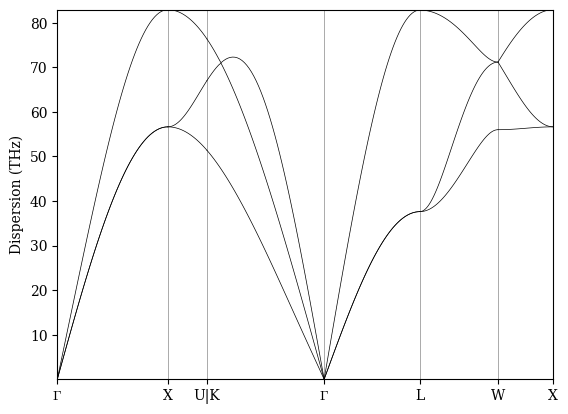

In [9]:
results['output_phonopy']['phonon_bands'].show_mpl()

Let's get the phonon band structure!

```{note}
This can also be done using the `PhonopyCalculation`, which will store the data inside the AiiDA repository. This is helpful if you want to calculate the band structure once, and then query for it (say, you need to compare many band structures).
```

/opt/conda/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_lattice']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_positions']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['std_types']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDataset['number']) is deprecated.Use attribute interface ({self.__class__.__name__}.{key}) instead
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/spglib/spglib.py:115: DeprecationWarning: dict interface (SpglibDatase

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.9/site-packages/matplotlib/pyplot.py'>

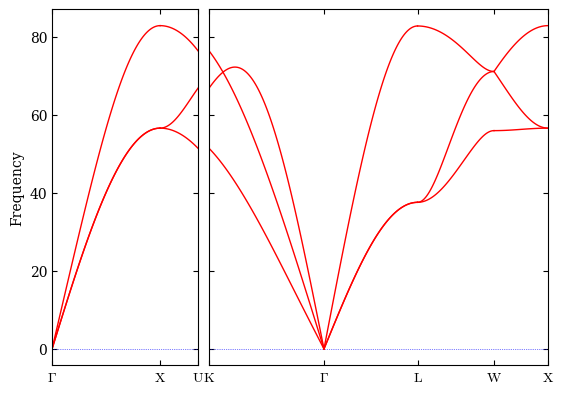

In [10]:
ph = node.outputs.phonopy_data.get_phonopy_instance()
ph.produce_force_constants()
ph.auto_band_structure(plot=True)